In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

ctl_color= "black"
exp_color="magenta"


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000

fig_folder= r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Presentations\2023\08_August\EBBS\EBBS_FIGS\\"
#f.savefig(figfolder + "timeline pellets delievered+.pdf")

In [2]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
              .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [43]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\METAFILE FEDXC DATA SHEETS.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
     
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))  


File is excel file. Making csv metafile first


In [47]:
def make_ff_df(df, mouse, diet,order, epoch):
    """
    Takes df of pellets - time and IPIs - and returns row for collated df
    """
    out = pd.DataFrame.from_dict({"mouse": [mouse],
                                  "diet": [diet],
                                  "order" : [int(order)],
                                  "epoch" : [epoch],
                                   
                                  "n_pellets": [len(df)],
                                  "n_meals": (df > 60).sum(),
                                  "session_time": (df.index[-1] - df.index[0]).total_seconds() / 60,
                                  "short_ipis": (df < 5).sum()
                                  })

    return (out
        
           .assign(meal_freq=lambda df_:1/  (df_.session_time / df_.n_meals) * 60 * 24,
                   meal_size=lambda df_: df_.n_pellets / df_.n_meals,
                   )
           .astype({"diet": "category",
                    "n_pellets": "uint16",
                    "n_meals": "uint16"}))


def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(meal_freq)
            
#              .reset_index()
            
           )

meal_freq=lambda df_:1/  (df_.session_time / df_.n_meals) * 60 * 24

In [38]:
ff = pd.DataFrame()
for key, val in ff_dict.items():
    
    pellets = val ["pellets"]
    mouse = val["mouse"]
    diet = val["diet"]
    order = val ["order"]
    epoch = val ["epoch"]
    ff = pd.concat([ff, make_ff_df(pellets, mouse, diet,order, epoch)])
    
ff.reset_index(drop=True, inplace=True);

In [40]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [41]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

In [64]:
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl)
exp_n_meals= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_n_meals.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_n_meals.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1)

######################################################################################
ax1.set_ylabel("Number of meals")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,107,"Epoch 1", ha="center")
ax1.text(10,107,"Epoch 2", ha="center")
ax1.text(17.5,107,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_n_meals.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_n_meals.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_n_meals.iloc[14:,:].mean(axis=0)

exp_E1=exp_n_meals.iloc[0:7,:].mean(axis=0)
exp_E2=exp_n_meals.iloc[7:14,:].mean(axis=0)
exp_E3=exp_n_meals.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend()

#f.savefig(fig_folder + "meal_number.png")


In [1]:
ctl


NameError: name 'ctl' is not defined

In [114]:
ctl_freq=[]
for x in ctl:
    ctl_freq.append(x/24) 
    print(ctl_freq)
    
exp_freq=[]
for x in exp:
    exp_freq.append(x/24)
    print(exp_freq)
    
    

ctl_t_freq= clean_df(ctl_freq)
exp_t_freq= clean_df(exp_freq)

[t
2022-09-12 08:00:00    3.666667
2022-09-13 08:00:00    2.958333
2022-09-14 08:00:00    3.708333
2022-09-15 08:00:00    3.750000
2022-09-16 08:00:00    3.541667
2022-09-17 08:00:00    4.125000
2022-09-18 08:00:00    3.875000
2022-09-19 08:00:00    4.625000
2022-09-20 08:00:00    4.333333
2022-09-21 08:00:00    4.041667
2022-09-22 08:00:00    4.291667
2022-09-23 08:00:00    4.083333
2022-09-24 08:00:00    3.958333
2022-09-25 08:00:00    3.750000
2022-09-26 08:00:00    3.750000
2022-09-27 08:00:00    4.708333
2022-09-28 08:00:00    3.833333
2022-09-29 08:00:00    3.875000
2022-09-30 08:00:00    3.375000
2022-10-01 08:00:00    3.291667
2022-10-02 08:00:00    3.375000
2022-10-03 08:00:00    3.375000
2022-10-04 08:00:00    2.583333
2022-10-05 08:00:00    2.583333
2022-10-06 08:00:00    2.125000
2022-10-07 08:00:00    3.208333
2022-10-08 08:00:00    2.875000
2022-10-09 08:00:00    3.416667
Freq: D, Name: n_meals, dtype: float64]
[t
2022-09-12 08:00:00    3.666667
2022-09-13 08:00:00    2.9

In [91]:
ctl_t_freq

,n_meals,n_meals,n_meals,n_meals,n_meals,n_meals
0,3.666667,4.791667,3.500000,2.583333,3.541667,4.833333
1,2.958333,3.958333,3.375000,2.500000,3.958333,4.583333
2,3.708333,4.916667,3.208333,2.375000,3.791667,4.125000
3,3.750000,4.333333,3.458333,2.833333,3.750000,4.041667
4,3.541667,3.666667,3.750000,2.416667,3.625000,3.791667
5,4.125000,3.708333,3.958333,2.333333,3.833333,3.708333
6,3.875000,3.875000,3.958333,2.458333,3.500000,3.083333
7,4.625000,4.333333,4.541667,2.750000,3.708333,3.583333
8,4.333333,3.666667,3.875000,2.750000,3.458333,3.583333
9,4.041667,4.041667,3.583333,2.500000,3.708333,3.791667


In [115]:
ctl_freq

[t
 2022-09-12 08:00:00    3.666667
 2022-09-13 08:00:00    2.958333
 2022-09-14 08:00:00    3.708333
 2022-09-15 08:00:00    3.750000
 2022-09-16 08:00:00    3.541667
 2022-09-17 08:00:00    4.125000
 2022-09-18 08:00:00    3.875000
 2022-09-19 08:00:00    4.625000
 2022-09-20 08:00:00    4.333333
 2022-09-21 08:00:00    4.041667
 2022-09-22 08:00:00    4.291667
 2022-09-23 08:00:00    4.083333
 2022-09-24 08:00:00    3.958333
 2022-09-25 08:00:00    3.750000
 2022-09-26 08:00:00    3.750000
 2022-09-27 08:00:00    4.708333
 2022-09-28 08:00:00    3.833333
 2022-09-29 08:00:00    3.875000
 2022-09-30 08:00:00    3.375000
 2022-10-01 08:00:00    3.291667
 2022-10-02 08:00:00    3.375000
 2022-10-03 08:00:00    3.375000
 2022-10-04 08:00:00    2.583333
 2022-10-05 08:00:00    2.583333
 2022-10-06 08:00:00    2.125000
 2022-10-07 08:00:00    3.208333
 2022-10-08 08:00:00    2.875000
 2022-10-09 08:00:00    3.416667
 Freq: D, Name: n_meals, dtype: float64,
 t
 2022-09-12 08:00:00    4.791

Text(20, 2.5, ' Exp')

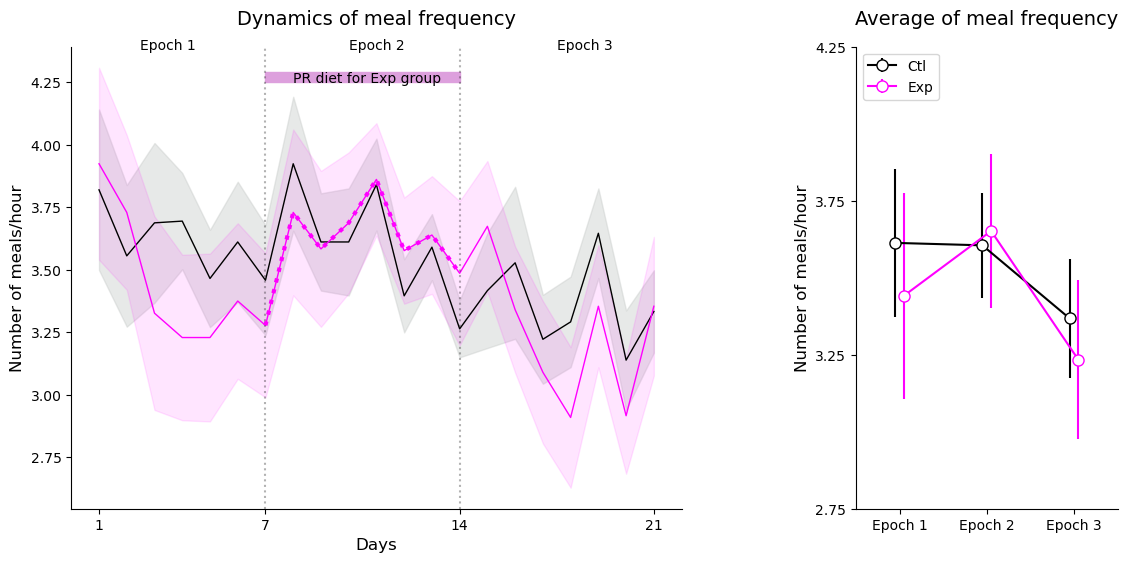

In [116]:
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))
##################################################################################
ctl_freq=[]
for x in ctl:
    ctl_freq.append(x/24) 
    # print(ctl_freq)
    
exp_freq=[]
for x in exp:
    exp_freq.append(x/24)
    # print(exp_freq)
    
#####################################################################################

ctl_t_freq= clean_df(ctl_freq)
exp_t_freq= clean_df(exp_freq)


###################################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=False,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_t_freq.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_t_freq.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

######################################################################################
ax1.set_ylabel("Number of meals/hour", fontsize= 12)
ax1.set_xlabel("Days", fontsize= 12)
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,4.38,"Epoch 1", ha="center")
ax1.text(10,4.38,"Epoch 2", ha="center")
ax1.text(17.5,4.38,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([4.29,4.25],[6], [13], color = "plum")
ax1.text(7,4.25,"PR diet for Exp group")
x=np.arange(6,14)
y=exp_t_freq.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_t_freq.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_t_freq.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_t_freq.iloc[14:,:].mean(axis=0)

exp_E1=exp_t_freq.iloc[0:7,:].mean(axis=0)
exp_E2=exp_t_freq.iloc[7:14,:].mean(axis=0)
exp_E3=exp_t_freq.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="-",
            markerfacecolor= "white",
            ms=8,
            color=ctl_color,
             label="Ctl")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="-",
             markerfacecolor="white",
             ms=8,
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([2.75,3.25,3.75,4.25])
ax2.set_ylabel("Number of meals/hour", fontsize = 12)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=2)

ax1.set_title("Dynamics of meal frequency", fontsize = 14, y=1.03)
ax2.set_title("Average of meal frequency", fontsize= 14,y=1.03)

f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,2.3])
ax1.annotate(" Exp",[20,2.5], color= exp_color)

#f.savefig(fig_folder + "mealsize.pdf")
